# Overview

Shannon Sirk and Catherine Liou collected some interested data on the pharmacokinetics of glucosinolates/isothiocyanates in gnotobiotic mice.  They dosed mice with benzyl glucosinolate (i.e. glucotropaeolin) three times and analyzed the N-acetyl cysteine (NAC) conjugate of benzyl isothiocyanate in mouse urine over a 48-hr period.  All mice in this dataset were monocolonized with wild-type _Bacteroides thetaomicron_ bacteria.  The three doses were:

1. a pure bolus of glucotropaeolin
2. a pure bolus of glucotropaeolin
3. a pure bolus of glucotropaeolin co-administered with broccoli juice / broccoli powder

Each dose was to the same five mice.  Thus, the dose variation was longitudinal across the same mice.

The data exhibited substantial mouse-to-mouse variability, but there seemed to be clear differences In this notebook I attempt to fit the data to some simple two-compartment PK models in order to estimate parameters.

In [1]:
require(tidyverse)
require(magrittr)
require(forcats)
require(stringr)
require(broom)
require(purrr)

Loading required package: tidyverse
Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Loading required package: magrittr

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

Loading required package: forcats
Loading required package: stringr
Loading required package: broom


## reshape the data into a tidyverse-suitable format

In [2]:

my.files <- list.files(path='from_catherine', pattern = "*.txt", full.names = T)

my.files

df <- data.frame()
for(fname in my.files){
    new.df <-
        read.table(fname, sep='\t', header = T, row.names = )
    new.df$file <- fname
    df <- rbind(df, new.df)
}

data.long <-
    df %>%
        gather(mouse, area, m1:m5) %>%
        mutate(round = str_extract(file, '(?<=[ ]R)[0-9](?:[ ])') %>% as.integer) %>%
        mutate(week = str_extract(file, '(?<=wk)[0-9]') %>% as.integer) %>%
        mutate(compound = 'BITC-NAC') %>%
        mutate(fraction = 'urine') %>%
        mutate(colonization = 'wt') %>%
        mutate(f = str_extract(file, '(?<=f)[0-9]') %>% as.integer) %>%
        unite(dose, f, week, sep='_', remove = F) %>%
        mutate(f = ifelse(is.na(f), 3, f)) %>%
        select(-file)

data.long

[1] "from_catherine/C_ BITC-NAC Urine WT R3 wk1 f1.txt"
[2] "from_catherine/C_ BITC-NAC Urine WT R3 wk1 f2.txt"
[3] "from_catherine/C_ BITC-NAC Urine WT R3 wk2.txt"

t,mouse,area,round,dose,week,compound,fraction,colonization,f
0,m1,6.560293,3,1_1,1,BITC-NAC,urine,wt,1
3,m1,756.622000,3,1_1,1,BITC-NAC,urine,wt,1
6,m1,92.325920,3,1_1,1,BITC-NAC,urine,wt,1
24,m1,8.183860,3,1_1,1,BITC-NAC,urine,wt,1
0,m1,8.183860,3,2_1,1,BITC-NAC,urine,wt,2
3,m1,1878.820000,3,2_1,1,BITC-NAC,urine,wt,2
6,m1,3755.784000,3,2_1,1,BITC-NAC,urine,wt,2
24,m1,70.927380,3,2_1,1,BITC-NAC,urine,wt,2
0,m1,30.744240,3,NA_2,2,BITC-NAC,urine,wt,3
3,m1,541.221900,3,NA_2,2,BITC-NAC,urine,wt,3


## Plot the data

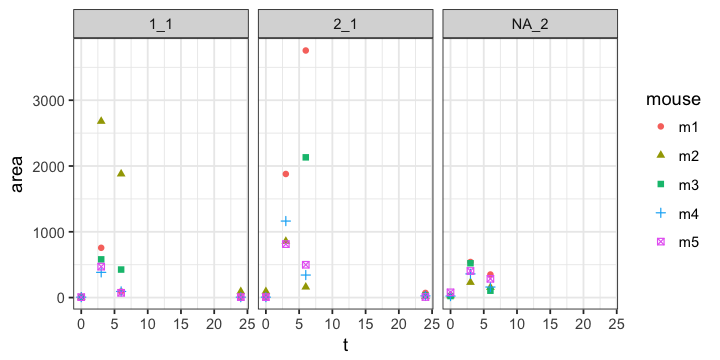

In [3]:
options(repr.plot.width=6, repr.plot.height=3)

data.long %>%
    na.omit() %>%
    ggplot(aes(x=t, y=area, shape=mouse, color=mouse)) +
        geom_point() +
        facet_grid(.~dose) +
        theme_bw()

## Fit the data for each dose to the RTD for two CSTRs in series

In [4]:
options(repr.plot.width=6, repr.plot.height=3)

modeled <- 
    data.long %>%
    na.omit() %>%
    mutate(norm_area = area / max(area)) %>%
    mutate(days = t / 24) %>%
    group_by(dose) %>%  # data for each dose separately
    do(tidy(nls(data = ., 
                formula = area ~ A * (days^2)/(2*tau_i^3) * (exp(-days/tau_i)),  # two-CSTR RTD equation 
                start = list(A = 1000, tau_i = 0.1)  # initial gues of parameters
               )
           )
      )

In [5]:
params <-
    modeled %>%
        select(dose, term, estimate) %>%
        group_by(dose) %>%
        spread(term, estimate)

## View the fitted parameters

In [6]:
modeled
params

dose,term,estimate,std.error,statistic,p.value
1_1,A,221.89697672,6.422648e+01,3.454914,3.025718e-03
1_1,tau_i,0.06163671,1.800547e-02,3.423221,3.240710e-03
2_1,A,542.85418166,2.189661e+02,2.479170,2.468630e-02
2_1,tau_i,0.10186874,3.539780e-02,2.877827,1.093240e-02
NA_2,A,92.62742349,9.938313e+00,9.320236,4.046310e-07
NA_2,tau_i,0.06084357,6.649207e-03,9.150500,4.988855e-07


dose,A,tau_i
1_1,221.89698,0.06163671
2_1,542.85418,0.10186874
NA_2,92.62742,0.06084357


## Plot the predicted data on the same graph as the raw data

In [7]:
prediction.space <-
    data.frame(days = rep((0:200)/100, 3),
               dose = rep(c('1_1', '2_1', 'NA_2'), 201) 
               ) %>%  # for a smooth curve use many data points
    left_join(params, by='dose') %>%  # bolt on the parameter values for each dose to every time point
    mutate(predicted_area = A * days/tau_i^2 * (exp(-days/tau_i)))  # calculate the predicted values


Warning message:
“Column `dose` joining factor and character vector, coercing into character vector”

Warning message:
“Removed 3 rows containing missing values (geom_point).”

Warning message:
“Removed 3 rows containing missing values (geom_point).”

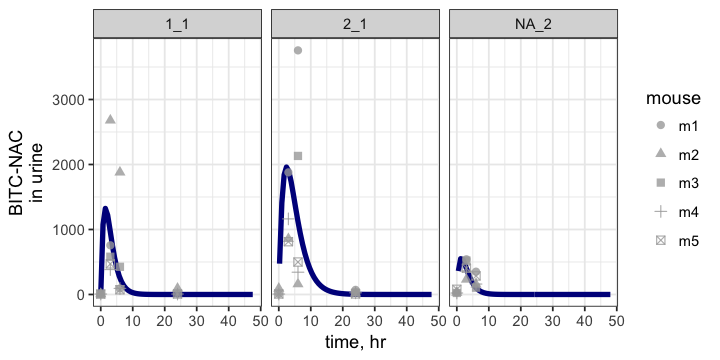

In [8]:
# do the plot
ggplot() + 
    geom_line(data=prediction.space, aes(x=days*24, y=predicted_area), color='dark blue', size=1.5) +
    facet_grid(.~dose, drop = T) +
    geom_point(data=data.long, aes(x=t, y=area, shape=mouse), size=2, alpha=0.8, color='dark gray') +
    theme_bw() +
    ylab('BITC-NAC\nin urine') +
    xlab('time, hr')

ggsave('example_of_fit.pdf', height=3, width=6)

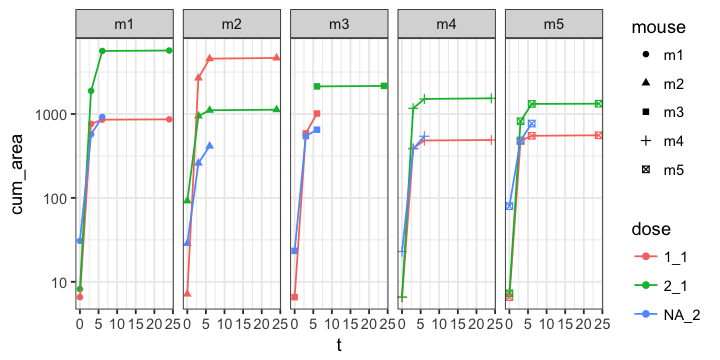

In [19]:
data.long %>%
    na.omit() %>%
    group_by(mouse, dose, week) %>%
    mutate(cum_area = cumsum(area)) %>%
    ggplot(aes(x=t, y=cum_area, color=dose, shape=mouse)) +
        geom_point() +
        geom_line() +
        facet_grid(. ~ mouse) +
        scale_y_log10() +
        theme_bw()